In [1]:
import numpy as np
import yaml
import math
import os
from utils import find_path_to_next_simulation
from MODSIM import initialize_dynamic_scene_with_random_tracks, perform_time_steps, create_and_place_simple_legacy_camera, calculate_start_state
from errorGenerator import ErrorGenerator
from datatypes.cameraRig import CameraRig
from datatypes.virtualCamera import VirtualCamera
from datatypes.conditionState import ConditionState

from visualize import visualize_projections_json_mov, visualize_annotations_json, visualize_camera_pose_in_dsg_mov, visualize_dynamic_scene_mov, visualize_detections_json, visualize_detections_multiple_cameras, visualize_annotations_multiple_cameras, visualize_projections_multiple_cameras


In [2]:
WAVE_MOTION = True

In [3]:
# Camera types: 'STATIC_LEGACY', 'DYNAMIC'
STATIC_LEGACY = 'STATIC_LEGACY'
DYNAMIC = 'DYNAMIC'
DYNAMIC_CORAL_CAMERA = 'DYNAMIC_CORAL_CAMERA'
DNV_CAM = 'DNV_CAM'
ZED ='ZED'
MID = 'MID'
LEFT = 'LEFT'
RIGHT = 'RIGHT'



CAMERA_TYPES = [STATIC_LEGACY]
CAMERA_PLACEMENTS = [MID, MID]
# Roll, yaw, pitch
ORIENTATION = [[0, 0, np.pi/200], [0, 0, np.pi/200]]

VESSEL_TO_PLACE_CAMERA_ON = 3

In [4]:
ERROR_CONFIG_PATH = 'detector_stats_config.yaml'
NUMBER_OF_VESSELS = 10
WRITE_TO_JSON = True
T_START = 0
T_END = 50
VISUALIZE=True
MIN_NUM_VESSELS = 1
ANNOTATION_MODE = 2


In [5]:
NO_DISTURBANCE  = 0
SMALL_DISTURBANCE  = 1
MEDIUM_DISTURBANCE  = 2
LARGE_DISTURBANCE  = 4
HUGE_DISTURBANCE  = 6


WAVE_INDUCED_CAMERA_DISTURBANCE_COEF = MEDIUM_DISTURBANCE  # int from 0-4

In [6]:
# Find folder to save simultation trial to
simulation_folder = find_path_to_next_simulation()
simulation_folder

'./simulations/6/'

# Initialize MODSIM

### Define condition based confusion matrices

In [7]:
numb_states = 4

with open('detector_stats_config.yaml', 'r') as stream:
            config = yaml.safe_load(stream)
if config.get('detectionConditions'):
    start_state = calculate_start_state(config.get('detectionConditions'), numb_states)
else:
    # Default is excellent weather
    start_state = calculate_start_state({'precipitation': 0, 'fog': 0, 'wind': 0, 'darkness': 0}, numb_states)

CM = config.get('confusionMatrix')
CM0 = {'FN': round(CM['FN']/3,3), 'FP': round(CM['FP']/3,3), 'TP': 1-round(CM['FN']/3,3), 'TN': 1 - round(CM['FP']/3,3)}
CM1 = {'FN': round(CM['FN']/1.5,3), 'FP': round(CM['FP']/1.5,3), 'TP': 1-round(CM['FN']/1.5,3), 'TN': 1 - round(CM['FP']/1.5,3)}
CM2 = {'FN': round(min(CM['FN']*1.5, 0.99),3), 'FP': round(min(CM['FP']*1.5, 0.99),3), 'TP': 1-round(min(CM['FN']*1.5, 0.99),3), 'TN': 1 - round(min(CM['FP']*1.5, 0.99),3)}
CM3 = {'FN': round(min(CM['FN']*3, 0.99),3), 'FP': round(min(CM['FP']*3, 0.99),3), 'TP': 1-round(min(CM['FN']*3, 0.99),3), 'TN': 1 - round(min(CM['FP']*3, 0.99),3)}


TM =  np.array([[0.996, 0.0017, 0.0006, 0.0006],[0.0022, 0.996, 0.0017, 0.0012],[0.0012, 0.0017, 0.996, 0.0022],[0.0006, 0.0006, 0.0017, 0.996]])
states = {0: ConditionState('Excellent conditions', 0, CM0), 1: ConditionState('Good conditions', 1, CM1), 2: ConditionState('Poor conditions', 2, CM2), 3: ConditionState('Terrible conditions', 3, CM3)}


#### Update class-based confusion matrix in the condition states

In [8]:
CM_label = config.get('confusionMatrixLabels')
false_positives_label = config.get('falsePositives')

cms_label = {}
state_multiplicate = [1/3, 1/1.5, 1.5, 3]
if CM_label:
    for s in range(numb_states):
        s_factor = state_multiplicate[s]
        all_new_values = {}
        for i, label in enumerate(CM_label.keys()):
            values = CM_label[label]
            drop_out = 1-sum(values)
            incorrect_detection = sum([e for indx, e in enumerate(values) if indx != i])+drop_out
            new_values = []
            for v in range(len(values)):
                if v == i:
                    new_values.append(round(1-min(incorrect_detection*s_factor,0.99), 3))
                else:
                    new_values.append(round(min(values[v]*s_factor, 0.99), 3))
            all_new_values[label] = new_values
        
        states[s].set_confusion_matrix_labels(all_new_values)

## Initialize dynamic scene

In [9]:
# Dynamic scene
dsg = initialize_dynamic_scene_with_random_tracks(NUMBER_OF_VESSELS, writeToJson=WRITE_TO_JSON, path=simulation_folder)
vessels = dsg.get_vessels()

## Error generator
errorGenerator = ErrorGenerator(ERROR_CONFIG_PATH, temporal_model=True, states=states, start_state=start_state, transition_matrix=TM)


### Camera

In [10]:
def get_pos_vcf(vessel, placement):
    if placement == LEFT:
        return np.array([vessel.get_length()/2, vessel.get_beam()/2, vessel.get_air_draft()/2])
    elif placement == RIGHT:
        return np.array([vessel.get_length()/2, -vessel.get_beam()/2, vessel.get_air_draft()/2])
    else:
        # Default MID
        return np.array([vessel.get_length()/2, 0, vessel.get_air_draft()/2])

In [26]:
camera.yaw_wcf

3.141592653589793

In [21]:
cameras = {}
for cameraID, cameraType in enumerate(CAMERA_TYPES):
    if cameraType == STATIC_LEGACY:
        ##### Static Camera #####
        # Create simple legacy camera and place it in the dynamic scene
        #camera = create_and_place_simple_legacy_camera(dsg.get_larges_radius(), dsg.get_path_centre(), height=20)
        camera = create_and_place_simple_legacy_camera(1000, dsg.get_path_centre(), height=20)
        ########################### OBS  ###################################################### 
        # If there is a static camera, there can only be one camera in the camera rig
        ####################################################################################### 
        cameras = {}
        cameras[0] = camera
        vessel = None
        break

    elif cameraType == DYNAMIC:
        ###### Dynamic Camera ######
        focal_length = 50*10**-3
        image_bounds = (3600, 2400) # Pixels (x,y)
        film_size = (36*10**-3, 24*10**-3)
        px = film_size[0]/image_bounds[0]
        py = film_size[1]/image_bounds[1]
        principal_point = (image_bounds[0]/2,image_bounds[1]/2)
        width_of_sensor = 36*10**-3 # Width of sensor
        
        # Pose
        roll_vcf = ORIENTATION[cameraID][0]
        yaw_vcf = ORIENTATION[cameraID][1]
        pitch_vcf = ORIENTATION[cameraID][2]
        vessel = vessels[VESSEL_TO_PLACE_CAMERA_ON] # Must be the same for al cameras in the camera rig
        pos_vcf = get_pos_vcf(vessel, CAMERA_PLACEMENTS[cameraID])


        camera = VirtualCamera(focal_length, px, py, principal_point, image_bounds)
        camera.place_camera_on_vessel(pos_vcf, roll_vcf, pitch_vcf, yaw_vcf)
    elif cameraType == DYNAMIC_CORAL_CAMERA:
        # https://www.tme.eu/Document/3e25990c825098a96a442d65b17c6632/CORAL-CAMERA-5MP.pdf
        ###### Dynamic Camera ######
        # Intrinsics
        # NB! Make sure everything is in meters
        focal_length = 2.5*10**-3
        image_bounds = (2592, 1933) # Pixels (x,y)
        #film_size = (1.4*10**-3, 1.4*10**-3)
        px = 1.4*10**-6
        py = 1.4*10**-6
        #px = 2*10**-6
        #py = 2*10**-6
        principal_point = (image_bounds[0]/2,image_bounds[1]/2)
        width_of_sensor = 36*10**-3 # Width of sensor

        # Pose
        roll_vcf = ORIENTATION[cameraID][0]
        yaw_vcf = ORIENTATION[cameraID][1]
        pitch_vcf = ORIENTATION[cameraID][2]
        vessel = vessels[VESSEL_TO_PLACE_CAMERA_ON]
        pos_vcf = get_pos_vcf(vessel, CAMERA_PLACEMENTS[cameraID])


        camera = VirtualCamera(focal_length, px, py, principal_point, image_bounds)
        camera.place_camera_on_vessel(pos_vcf, roll_vcf, pitch_vcf, yaw_vcf)
    elif cameraType == ZED:
        # Intrinsics
        # NB! Make sure everything is in meters
        focal_length = 2.8*10**-3
        image_bounds = (2688, 1520) # Pixels (x,y)
        #film_size = (1.4*10**-3, 1.4*10**-3)
        fx = 1404.2700
        fy = 1404.8199
        px = focal_length/fx
        py = focal_length/fy
        #px = 2*10**-6
        #py = 2*10**-6
        principal_point = (1110.9700,614.7650)

        # Pose
        roll_vcf = ORIENTATION[cameraID][0]
        yaw_vcf = ORIENTATION[cameraID][1]
        pitch_vcf = ORIENTATION[cameraID][2]
        vessel = vessels[VESSEL_TO_PLACE_CAMERA_ON]
        pos_vcf = get_pos_vcf(vessel, CAMERA_PLACEMENTS[cameraID])


        camera = VirtualCamera(focal_length, px, py, principal_point, image_bounds)
        camera.place_camera_on_vessel(pos_vcf, roll_vcf, pitch_vcf, yaw_vcf)
    elif cameraType == DNV_CAM:
        width = 2464
        height = 2056
        h_fov = 55 # degrees

        # NB! Make sure everything is in meters
        image_bounds = (2464, 2056) # Pixels (x,y)

        p = height / width
        focal_length = (float(width) * 0.5) / math.tan(
            math.radians(h_fov * 0.5))*10**-6  # Calculating the focal length from the FoV
        cam = np.eye(3, dtype=np.float32)
        cx = width * 0.5  # define center x
        cy = height * 0.5  # define center y
        fx = focal_length # define focal length x
        fy = focal_length * p  # (vFov / fov)  # define focal length y scaled to vertical fov
        px = 1*10**-6
        py = p*10**-6

        principal_point = (cx,cy)

        # Pose
        roll_vcf = ORIENTATION[cameraID][0]
        yaw_vcf = ORIENTATION[cameraID][1]
        pitch_vcf = ORIENTATION[cameraID][2]
        vessel = vessels[VESSEL_TO_PLACE_CAMERA_ON]
        pos_vcf = get_pos_vcf(vessel, CAMERA_PLACEMENTS[cameraID])


        camera = VirtualCamera(focal_length, px, py, principal_point, image_bounds)
        camera.place_camera_on_vessel(pos_vcf, roll_vcf, pitch_vcf, yaw_vcf)
    # elif cameraType == OTHER TYPES:
        
    cameras[cameraID] = camera

camera_rig = CameraRig(cameras, vessel, wave_induced_camera_disturbance_coef=WAVE_INDUCED_CAMERA_DISTURBANCE_COEF)


# Perform time steps

In [16]:
#pps, bbs, eBBs = perform_one_time_step_class(dsg, errorGenerator, camera_rig, 0, writeToJson=WRITE_TO_JSON, path=simulation_folder)

In [17]:
pps, bbs, eBBs = perform_time_steps(T_START, T_END, dsg, errorGenerator, camera_rig, annotation_mode=ANNOTATION_MODE, writeToJson=WRITE_TO_JSON, path=simulation_folder)

# Visualize

Moviepy - Building video ./simulations/6/camera_position.mp4.
Moviepy - Writing video ./simulations/6/camera_position.mp4



Moviepy - Done !
Moviepy - video ready ./simulations/6/camera_position.mp4
Loading projections from json
Visualizing projections
Moviepy - Building video ./simulations/6/projectedPoints_C0.mp4.
Moviepy - Writing video ./simulations/6/projectedPoints_C0.mp4



Moviepy - Done !
Moviepy - video ready ./simulations/6/projectedPoints_C0.mp4


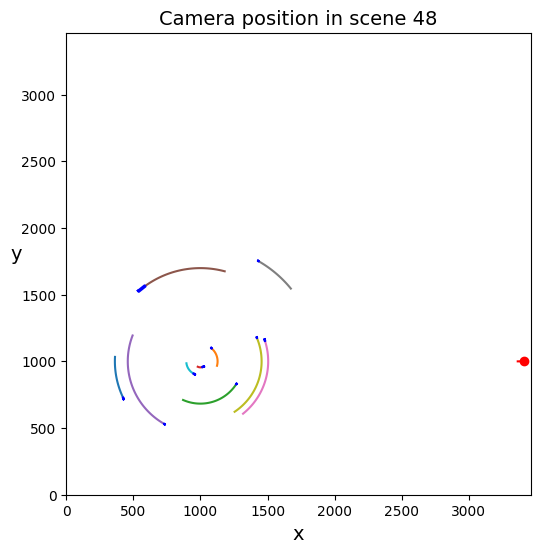

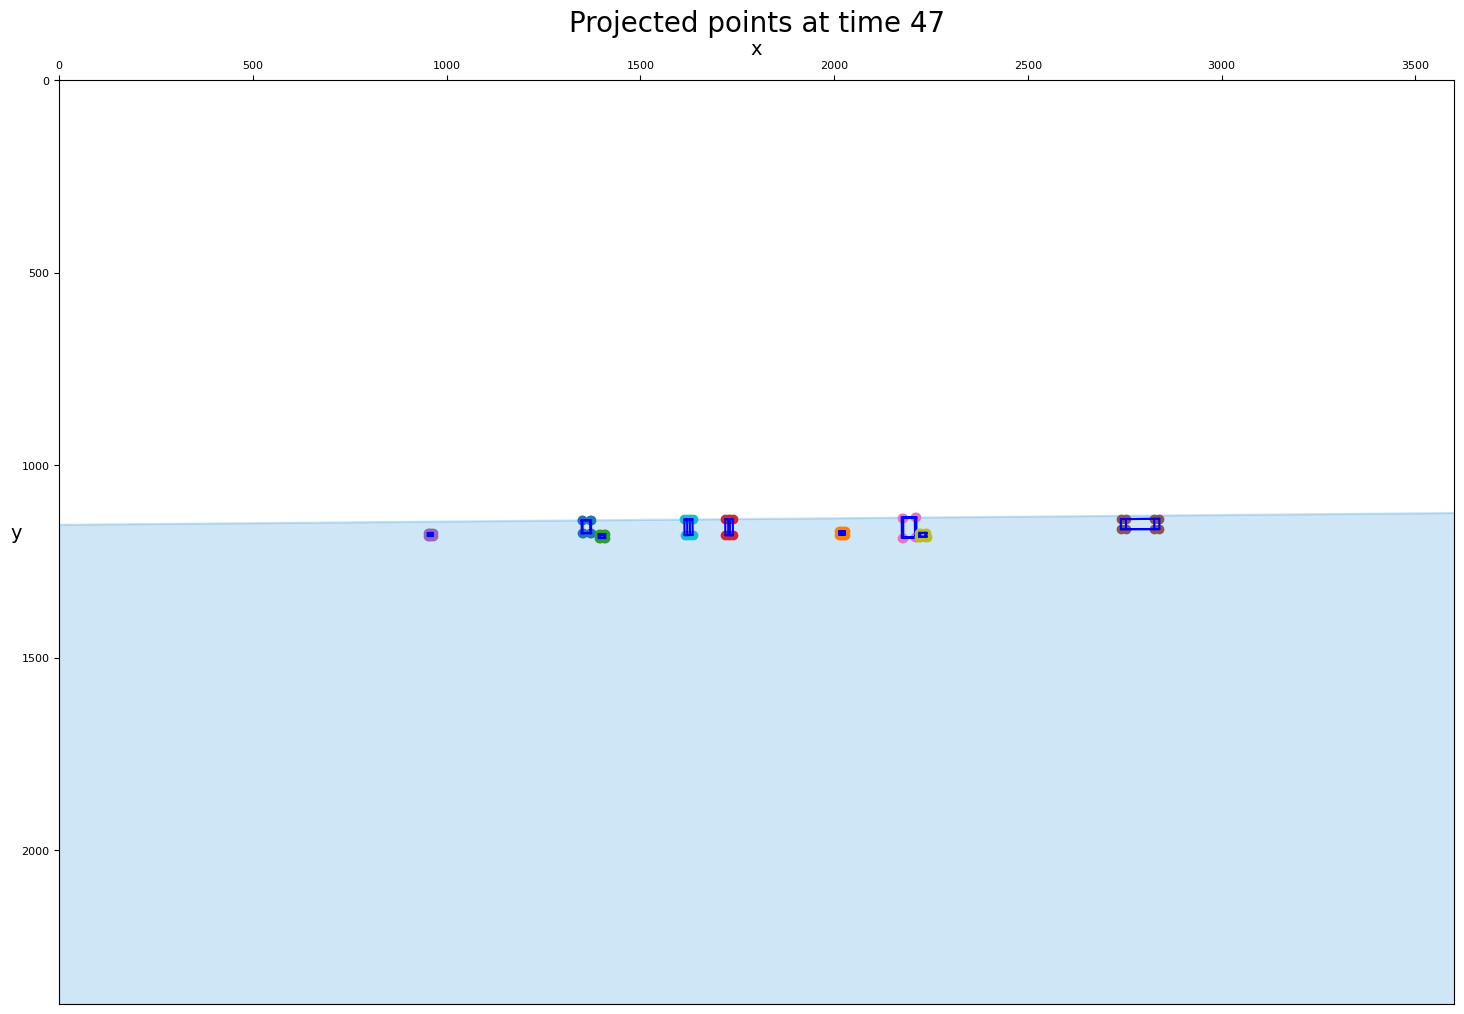

In [18]:
# Visualize from json files
if VISUALIZE:
    #x_y_lim = dsg.get_larges_radius() + 1050
    x_y_lim = 2000
    if STATIC_LEGACY in CAMERA_TYPES:
        x_y_lim = None
    pps_paths = {cameraID: os.path.join(simulation_folder, f'projectedPoints_C{cameraID}.json') for cameraID in cameras.keys()}
    annots_paths = {cameraID: os.path.join(simulation_folder, f'annotations_C{cameraID}.json') for cameraID in cameras.keys()}
    detections_paths = {cameraID: os.path.join(simulation_folder, f'detections_C{cameraID}.json') for cameraID in cameras.keys()}
    image_bounds = {cameraID: camera_rig.cameras[cameraID].image_bounds for cameraID in cameras.keys()}
    cameraIDs = list(cameras.keys())

    #visualize_dynamic_scene_mov(vessels, folder_path=simulation_folder)
    #visualize_camera_pose_in_dsg_mov(camera_rig, vessels, folder_path=simulation_folder, y_x_lim=x_y_lim)
    visualize_projections_multiple_cameras(cameraIDs, pps_paths, image_bounds, camera_rig.horizon, folder_path=simulation_folder, display_when_min_vessels=MIN_NUM_VESSELS)
    #visualize_annotations_multiple_cameras(cameraIDs, annots_paths, image_bounds, horizons=camera_rig.horizon, folder_path=simulation_folder, display_when_min_vessels=MIN_NUM_VESSELS)
    #visualize_detections_multiple_cameras(cameraIDs, detections_paths, image_bounds, horizons=camera_rig.horizon, show_annotations=True, annotations_paths=annots_paths, folder_path=simulation_folder, display_when_min_vessels=MIN_NUM_VESSELS, temporal_state_history=errorGenerator.temporal_model.previous_states, temporal_state_names=errorGenerator.temporal_model.state_names)